# Configure Cluster Module Params

This notebook should be used as a test for ensuring correct cluster parameters before cluster processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for cluster module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
from matplotlib import pyplot as plt

from lib.cluster.cluster_eval import plot_cell_histogram
from lib.cluster.generate_dataset import (
    clean_and_validate,
    split_channels,
    remove_low_number_genes,
    remove_missing_features,
)
from lib.cluster.phate_leiden_clustering import (
    select_features,
    normalize_to_controls,
    perform_pca_analysis,
    phate_leiden_pipeline,
    dimensionality_reduction,
    merge_phate_uniprot,
)
from lib.cluster.benchmark_clusters import (
    create_cluster_gene_table,
    analyze_differential_features,
    process_interactions,
)
from lib.cluster.scrape_benchmarks import (
    get_uniprot_data,
    get_string_data,
    get_corum_data,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
    ROOT_FP = Path(config["all"]["root_fp"])

## <font color='red'>SET PARAMETERS</font>

### Cluster processing

- `CHANNEL_COMBOS`: Combinations of channels to use during cluster process.
- `DATASET_TYPES`: Dataset types to use during cluster process; created during the aggregate process.
- `MIN_CELL_CUTOFFS`: Minimum cells for each gene to be used in clusetering analysis. More cells per gene increases confidence, but some dataset types (ex mitotic) may have an inherently low number of cells for a particular perturbation.

In [4]:
# parameters for all cluster processing
CHANNEL_COMBOS = [
    ["DAPI", "COXIV", "CENPA", "WGA"],
    ["DAPI", "CENPA"],
]
DATASET_TYPES = ["mitotic", "interphase", "all"]
MIN_CELL_CUTOFFS = {"mitotic": 0, "interphase": 3, "all": 3}

Cell count distribution for: mitotic
Number of genes below cutoff: 0
[]


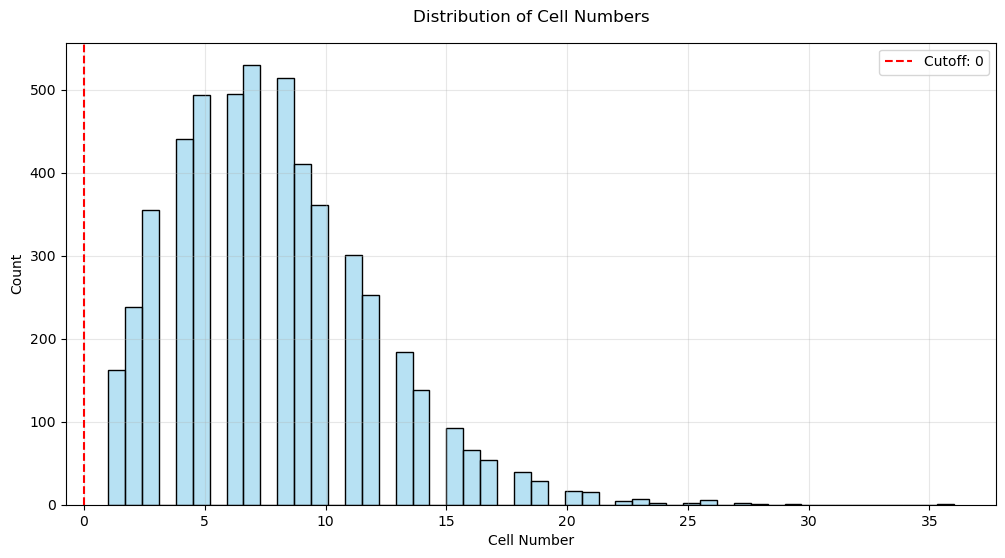

Cell count distribution for: interphase
Number of genes below cutoff: 0
[]


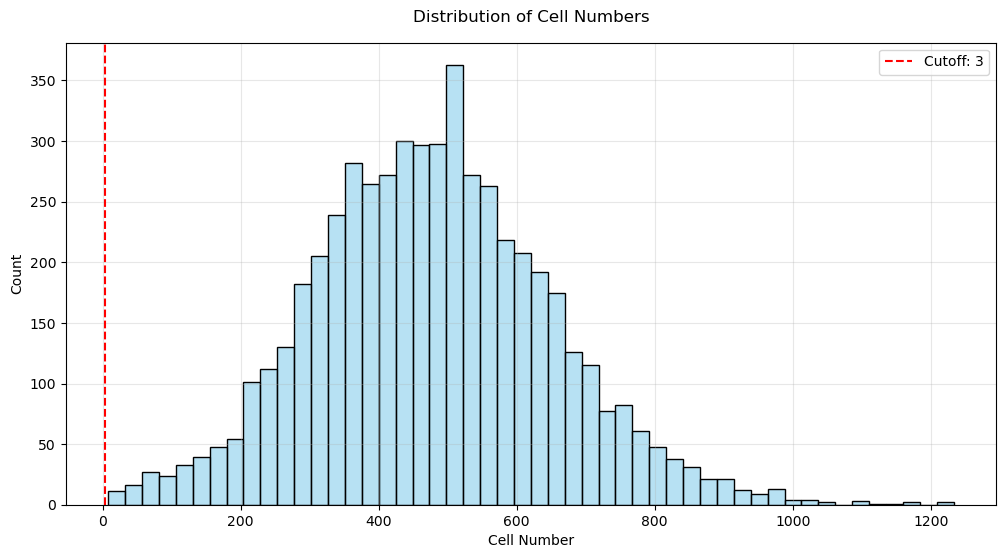

Cell count distribution for: all
Number of genes below cutoff: 0
[]


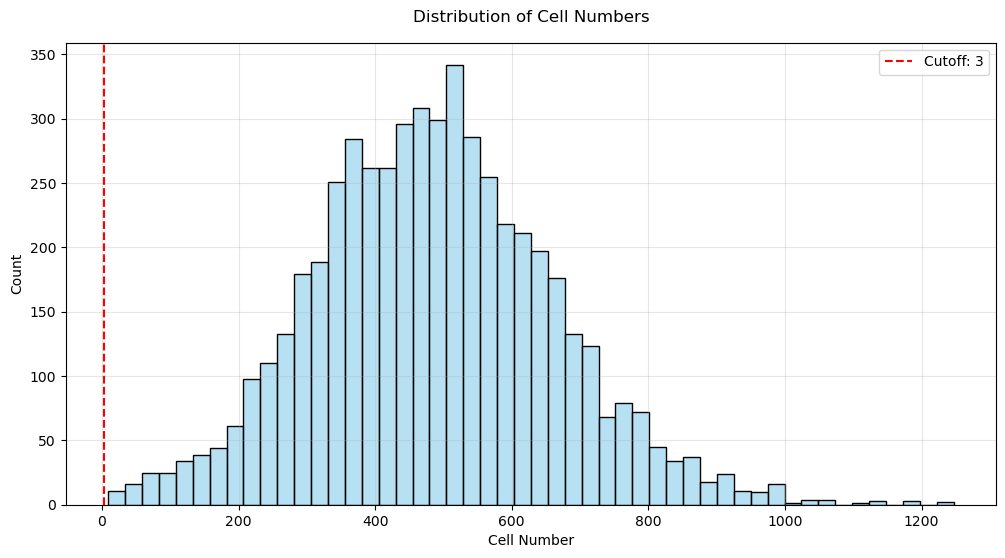

In [5]:
for dataset_type, min_cell_cutoff in MIN_CELL_CUTOFFS.items():
    # load and clean relevant dataset
    gene_data_fp = ROOT_FP / "aggregate" / "tsvs" / f"{dataset_type}_gene_data.tsv"
    gene_data = pd.read_csv(gene_data_fp, sep="\t")
    cleaned_data = clean_and_validate(gene_data)

    # show cell count distribution
    print(f"Cell count distribution for: {dataset_type}")
    plot_cell_histogram(cleaned_data, min_cell_cutoff)
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Cluster testing

- `TEST_CHANNEL_COMBO`: Channel combination to use for testing cluster process. Should be smallest or most relevant channel combination.
- `TEST_DATASET_TYPE`: Dataset type to use for testing cluster process. Should be smallest or most relevant dataset type.

In [6]:
# parameters for testing cluster processing
TEST_CHANNEL_COMBO = ["DAPI", "CENPA"]
TEST_DATASET_TYPE = "mitotic"

In [7]:
# load gene data based on dataset we are processing
gene_data_fp = ROOT_FP / "aggregate" / "tsvs" / f"{TEST_DATASET_TYPE}_gene_data.tsv"
gene_data = pd.read_csv(gene_data_fp, sep="\t")

# clean and validate gene data
validated_data = clean_and_validate(gene_data)

# filter dataset for channels of interest
channel_filtered_data = split_channels(
    validated_data,
    TEST_CHANNEL_COMBO,
    config["phenotype"]["channel_names"],
)

# clean low number genes and missing features
cleaned_data = remove_low_number_genes(
    channel_filtered_data, MIN_CELL_CUTOFFS[TEST_DATASET_TYPE]
)
cleaned_data = remove_missing_features(cleaned_data)

cleaned_data


Gene Filtering Summary:
Original genes: 5214
Genes with < 0 cells: 0
Remaining genes: 5214

Feature Cleaning Summary:
Original features: 887

Removed features:

Features with infinite values (35):
- nucleus_DAPI_pftas_7
- nucleus_DAPI_pftas_8
- nucleus_DAPI_pftas_15
- nucleus_DAPI_pftas_16
- nucleus_DAPI_pftas_17
- nucleus_DAPI_pftas_24
- nucleus_DAPI_pftas_25
- nucleus_DAPI_pftas_26
- nucleus_DAPI_pftas_34
- nucleus_DAPI_pftas_35
- nucleus_DAPI_pftas_42
- nucleus_DAPI_pftas_43
- nucleus_DAPI_pftas_44
- nucleus_DAPI_pftas_52
- nucleus_DAPI_pftas_53
- cell_DAPI_pftas_7
- cell_DAPI_pftas_8
- cell_DAPI_pftas_15
- cell_DAPI_pftas_16
- cell_DAPI_pftas_17
- cell_DAPI_pftas_24
- cell_DAPI_pftas_25
- cell_DAPI_pftas_26
- cell_DAPI_pftas_34
- cell_DAPI_pftas_35
- cell_DAPI_pftas_42
- cell_DAPI_pftas_43
- cell_DAPI_pftas_51
- cell_DAPI_pftas_52
- cell_DAPI_pftas_53
- cytoplasm_DAPI_pftas_15
- cytoplasm_DAPI_pftas_34
- cytoplasm_DAPI_pftas_35
- cytoplasm_DAPI_pftas_43
- cytoplasm_DAPI_pftas_53



,gene_symbol_0,cell_number,nucleus_DAPI_mean,nucleus_CENPA_mean,nucleus_DAPI_std,nucleus_CENPA_std,nucleus_DAPI_max,nucleus_CENPA_max,nucleus_DAPI_min,nucleus_CENPA_min,...,cytoplasm_bounds_3,nucleus_first_neighbor_distance,nucleus_second_neighbor_distance,nucleus_angle_between_neighbors,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,AAAS,8,-0.262259,-0.339949,-0.512859,-0.010294,-0.411154,-0.252186,0.048417,0.049473,...,0.820264,0.102842,-0.343691,0.812041,0.180065,-0.392125,0.833213,0.221852,-0.385298,0.981101
1,AAGAB,12,-0.044904,-0.082009,-0.308612,-0.343219,-0.291390,-0.269322,-0.189964,0.004768,...,-0.131682,0.637839,0.580113,0.678063,0.665681,0.533715,0.672681,0.600674,0.638515,0.580504
2,AAK1,8,0.121423,-0.827550,0.001548,0.111190,-0.362389,-0.369795,-0.691036,-0.615359,...,-0.118498,0.372944,0.100797,-0.150537,0.500435,0.127708,-0.015558,0.385066,0.099651,-0.173116
3,AAMP,6,0.734677,2.590474,0.322162,0.803227,0.454678,1.732049,0.854141,1.495630,...,0.119870,0.493253,0.134442,0.748740,0.521377,0.220522,0.835274,0.289885,0.442488,-0.218326
4,AARS1,7,0.283863,0.795977,0.414115,0.786276,0.427047,0.657846,-0.310625,0.425228,...,-0.197007,0.422420,0.033221,0.708501,0.575370,0.269292,0.265564,0.828964,0.381475,0.214894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,nontargeting_95,3,-0.160815,0.578069,0.062080,0.981065,-0.282120,0.174870,-0.644039,0.058652,...,0.475267,0.242469,-0.276211,0.513734,0.525716,-0.165286,0.617073,0.874070,-0.080161,0.680795
5210,nontargeting_96,1,1.308307,-1.497512,0.524100,-1.998227,0.402671,-1.978831,0.753699,-1.019976,...,-0.837003,-0.014503,-0.477400,-1.269397,0.025008,-0.511032,-1.348987,0.146076,-0.465987,-1.290614
5211,nontargeting_97,6,0.662350,0.386715,0.033893,-0.337001,0.149488,0.130914,0.279629,0.592423,...,-0.424828,0.189246,0.047720,-0.052403,0.210371,-0.032532,-0.036116,0.352872,0.166095,0.141601
5212,nontargeting_98,1,-0.167477,0.364020,0.807015,0.436577,0.584549,0.266469,-0.757541,-0.102641,...,1.130378,-0.183443,1.003972,-0.382197,-0.176070,0.953261,-0.202525,-0.076042,0.943427,0.045637


## <font color='red'>SET PARAMETERS</font>

### Feature selection

- `CORRELATION_THRESHOLD`: Features with a correlation (to another feature) above this threshold are iteratively removed to get "unique" features.
- `VARIANCE_THRESHOLD`: Features with variance below this threshold are removed.
- `MIN_UNIQUE_VALUES`: Features with a number of unique values below this threshold are removed.

In [8]:
# parameters used for feature selection
CORRELATION_THRESHOLD = 0.99
VARIANCE_THRESHOLD = 0.001
MIN_UNIQUE_VALUES = 5

In [9]:
# select features
filtered_data, removed_features = select_features(
    cleaned_data,
    correlation_threshold=CORRELATION_THRESHOLD,
    variance_threshold=VARIANCE_THRESHOLD,
    min_unique_values=MIN_UNIQUE_VALUES,
)

filtered_data


Feature Selection Summary:
Original features: 752
Features removed due to correlation: 73
Features removed due to low variance: 0
Features removed due to few unique values: 0
Final features: 679


,gene_symbol_0,nucleus_DAPI_mean,nucleus_CENPA_mean,nucleus_DAPI_std,nucleus_CENPA_std,nucleus_CENPA_max,nucleus_DAPI_min,nucleus_DAPI_int_edge,nucleus_CENPA_int_edge,nucleus_DAPI_mean_edge,...,cytoplasm_zernike_9_9,nucleus_first_neighbor_distance,nucleus_second_neighbor_distance,nucleus_angle_between_neighbors,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,AAAS,-0.262259,-0.339949,-0.512859,-0.010294,-0.252186,0.048417,0.118804,0.044903,0.172146,...,-0.005515,0.102842,-0.343691,0.812041,0.180065,-0.392125,0.833213,0.221852,-0.385298,0.981101
1,AAGAB,-0.044904,-0.082009,-0.308612,-0.343219,-0.269322,-0.189964,0.254456,-0.391118,0.014393,...,-0.324518,0.637839,0.580113,0.678063,0.665681,0.533715,0.672681,0.600674,0.638515,0.580504
2,AAK1,0.121423,-0.827550,0.001548,0.111190,-0.369795,-0.691036,-0.450386,-0.464314,-0.405857,...,0.183470,0.372944,0.100797,-0.150537,0.500435,0.127708,-0.015558,0.385066,0.099651,-0.173116
3,AAMP,0.734677,2.590474,0.322162,0.803227,1.732049,0.854141,1.287056,2.095766,2.164386,...,0.201259,0.493253,0.134442,0.748740,0.521377,0.220522,0.835274,0.289885,0.442488,-0.218326
4,AARS1,0.283863,0.795977,0.414115,0.786276,0.657846,-0.310625,-0.433952,0.632183,-0.383881,...,-0.651063,0.422420,0.033221,0.708501,0.575370,0.269292,0.265564,0.828964,0.381475,0.214894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,nontargeting_95,-0.160815,0.578069,0.062080,0.981065,0.174870,-0.644039,-0.444707,0.563620,-0.520791,...,0.440656,0.242469,-0.276211,0.513734,0.525716,-0.165286,0.617073,0.874070,-0.080161,0.680795
5210,nontargeting_96,1.308307,-1.497512,0.524100,-1.998227,-1.978831,0.753699,0.538444,-0.965966,1.071560,...,1.649204,-0.014503,-0.477400,-1.269397,0.025008,-0.511032,-1.348987,0.146076,-0.465987,-1.290614
5211,nontargeting_97,0.662350,0.386715,0.033893,-0.337001,0.130914,0.279629,0.570774,0.424150,1.254293,...,-0.432349,0.189246,0.047720,-0.052403,0.210371,-0.032532,-0.036116,0.352872,0.166095,0.141601
5212,nontargeting_98,-0.167477,0.364020,0.807015,0.436577,0.266469,-0.757541,-0.515093,1.155540,-1.687735,...,-0.938927,-0.183443,1.003972,-0.382197,-0.176070,0.953261,-0.202525,-0.076042,0.943427,0.045637


## <font color='red'>SET PARAMETERS</font>

### Phate/Leiden Clustering

- `CUM_VAR_THRESHOLD`: Minimum cumulative variance that needs to be explained by selected PCA features. Higher variance = more features.
- `LEIDEN_RESOLUTION`: Resolution for Leiden clustering. 

In [10]:
CUM_VAR_THRESHOLD = 0.99
LEIDEN_RESOLUTION = 15

Number of components needed for 99.0% variance: 34
Shape of input data: (5214, 679)
Shape of PCA transformed and reduced data: (5214, 34)
Calculating PHATE...
  Running PHATE on 5214 observations and 34 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.43 seconds.
    Calculating affinities...
    Calculated affinities in 0.28 seconds.
  Calculated graph and diffusion operator in 1.80 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 39.75 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.98 seconds.
  Calculated landmark operator in 48.29 seconds.
  Calculating optimal t...
    Automatically selected t = 3
  Calculated optimal t in 428.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.15 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.75 seconds.
Calculated PHATE in 489.56 seconds.
Number of clusters: 286
Average 

<Axes: xlabel='PHATE_0', ylabel='PHATE_1'>

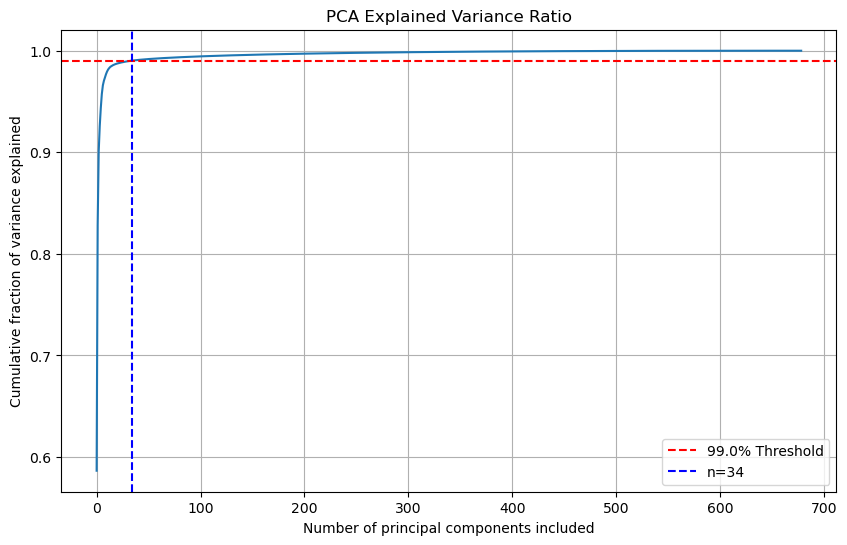

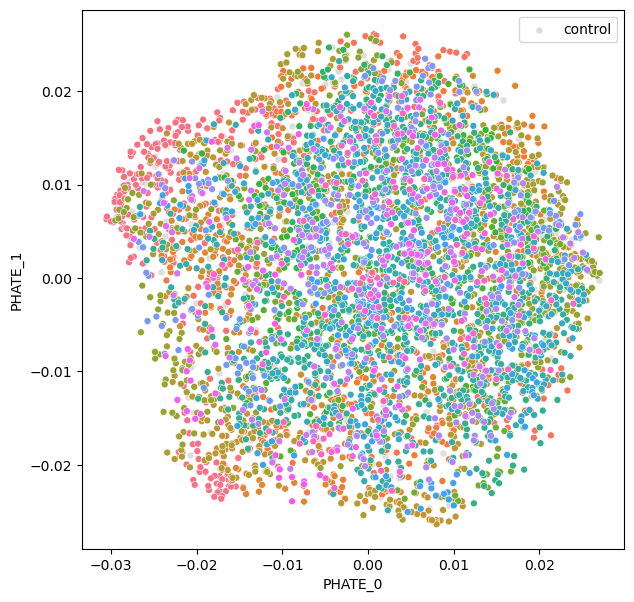

In [11]:
CONTROL_PREFIX = config["aggregate"]["control_prefix"]
POPULATION_FEATURE = config["aggregate"]["population_feature"]

# normalize filtered data
normalized_data = normalize_to_controls(filtered_data, CONTROL_PREFIX)

# threshold data with pca
pca_thresholded_data, n_components, pca, fig = perform_pca_analysis(
    normalized_data, CUM_VAR_THRESHOLD
)
fig.show()

# perform phate leiden clustering
phate_leiden_clustering = phate_leiden_pipeline(
    pca_thresholded_data, resolution=LEIDEN_RESOLUTION
)

# create plot with phate leiden clustering
dimensionality_reduction(
    phate_leiden_clustering,
    x="PHATE_0",
    y="PHATE_1",
    control_query=f'{POPULATION_FEATURE}.str.startswith("{CONTROL_PREFIX}")',
    control_color="lightgray",
    control_legend=True,
    label_query=f'~{POPULATION_FEATURE}.str.startswith("{CONTROL_PREFIX}")',
    label_hue="cluster",
    label_palette="husl",
    s=25,
    hide_axes=False,
    label_legend=False,
    legend_kwargs={"loc": "center left", "bbox_to_anchor": (1, 0.5)},
)

## <font color='red'>SET PARAMETERS</font>

### Cluster Analysis

- `UNIPROT_DATA_FP`: Path to save and access UniProt data with gene descriptions.
- `STRING_DATA_FP`: Path to save and access STRING data with gene pairs.
- `CORUM_DATA_FP`: Path to save and access CORUM data with gene complexes.

In [ ]:
UNIPROT_DATA_FP = "config/benchmark_clusters/uniprot_data.tsv"
STRING_DATA_FP = "config/benchmark_clusters/string_data.tsv"
CORUM_DATA_FP = "config/benchmark_clusters/corum_data.tsv"

In [13]:
# get and save uniprot data
uniprot_data = get_uniprot_data()
uniprot_data.to_csv(UNIPROT_DATA_FP, sep="\t", index=False)
display(uniprot_data)

# get and save string data
string_data = get_string_data()
string_data.to_csv(STRING_DATA_FP, sep="\t", index=False)
display(string_data)

# get and save corum data
corum_data = get_corum_data()
corum_data.to_csv(CORUM_DATA_FP, sep="\t", index=False)
display(corum_data)

Fetching UniProt data...
Progress: 500 / 20417
Progress: 1001 / 20417
Progress: 1502 / 20417
Progress: 2003 / 20417
Progress: 2504 / 20417
Progress: 3005 / 20417
Progress: 3506 / 20417
Progress: 4007 / 20417
Progress: 4508 / 20417
Progress: 5009 / 20417
Progress: 5510 / 20417
Progress: 6011 / 20417
Progress: 6512 / 20417
Progress: 7013 / 20417
Progress: 7514 / 20417
Progress: 8015 / 20417
Progress: 8516 / 20417
Progress: 9017 / 20417
Progress: 9518 / 20417
Progress: 10019 / 20417
Progress: 10520 / 20417
Progress: 11021 / 20417
Progress: 11522 / 20417
Progress: 12023 / 20417
Progress: 12524 / 20417
Progress: 13025 / 20417
Progress: 13526 / 20417
Progress: 14027 / 20417
Progress: 14528 / 20417
Progress: 15029 / 20417
Progress: 15530 / 20417
Progress: 16031 / 20417
Progress: 16532 / 20417
Progress: 17033 / 20417
Progress: 17534 / 20417
Progress: 18035 / 20417
Progress: 18536 / 20417
Progress: 19037 / 20417
Progress: 19538 / 20417
Progress: 20039 / 20417
Progress: 20457 / 20417
Completed. 

,Gene Names,Function [CC],KEGG,ComplexPortal,STRING
0,MT-RNR1,FUNCTION: Regulates insulin sensitivity and me...,,,
1,CIROP LMLN2,FUNCTION: Putative metalloproteinase that play...,,,
2,BLTP3B KIAA0701 SHIP164 UHRF1BP1L,FUNCTION: Tube-forming lipid transport protein...,hsa:23074;,,9606.ENSP00000279907;
3,POTEB3,,hsa:102724631;,,9606.ENSP00000483103;
4,CLRN2,FUNCTION: Plays a key role to hearing function...,hsa:645104;,,9606.ENSP00000424711;
...,...,...,...,...,...
20452,LINC00597 C15orf5,,,,
20453,PRO3102,,,,
20454,PRO2829,,,,
20455,,,,,


Fetching STRING data...
Completed. Total interactions: 117118


,protein1,protein2,combined_score
160,9606.ENSP00000000233,9606.ENSP00000262305,952
1396,9606.ENSP00000000412,9606.ENSP00000438085,993
1583,9606.ENSP00000000412,9606.ENSP00000371175,957
1601,9606.ENSP00000000412,9606.ENSP00000349437,991
1780,9606.ENSP00000001008,9606.ENSP00000351646,979
...,...,...,...
13714840,9606.ENSP00000501277,9606.ENSP00000268679,991
13714879,9606.ENSP00000501277,9606.ENSP00000294339,999
13714880,9606.ENSP00000501277,9606.ENSP00000264824,968
13715299,9606.ENSP00000501317,9606.ENSP00000305071,978


Fetching CORUM data...


/lab/barcheese01/rkern/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mips.helmholtz-muenchen.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Completed. Total complexes: 5366


,complex_id,complex_name,synonyms,organism,cell_line,pmid,comment_complex,comment_members,comment_disease,comment_drug,...,functions_go_name,functions_go_ontology,fcgs_description,fcgs_id,fcgs_name,fcgs_category_id,fcgs_category_name,fcgs_go_id,fcgs_go_name,fcgs_go_ontology
0,1,BCL6-HDAC4 complex,NaN,Human,U2OS osteosarcoma-derived UTA-L cells,11929873,Transcriptional repression by BCL6 is thought ...,NaN,NaN,NaN,...,histone deacetylase activity;nucleus;DNA topol...,molecular_function;cellular_component;biologic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,BCL6-HDAC5 complex,NaN,Human,U2OS osteosarcoma-derived UTA-L cells,11929873,Transcriptional repression by BCL6 is thought ...,NaN,NaN,NaN,...,histone deacetylase activity;nucleus;DNA topol...,molecular_function;cellular_component;biologic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,BCL6-HDAC7 complex,NaN,Human,U2OS osteosarcoma-derived UTA-L cells,11929873,Transcriptional repression by BCL6 is thought ...,NaN,NaN,NaN,...,histone deacetylase activity;nucleus;DNA topol...,molecular_function;cellular_component;biologic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Multisubunit ACTR coactivator complex,NaN,Human,different human tissues and cancer cell lines,9267036,Cofactor ACTR binds directly nuclear receptors...,NaN,NaN,NaN,...,histone acetyltransferase activity;nuclear rec...,molecular_function;molecular_function,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,Condensin I complex,13S condensin complex,Human,HeLa cells,11136719,NaN,NaN,NaN,NaN,...,mitotic cell cycle;M phase;chromosome;chromoso...,biological_process;biological_process;cellular...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5361,11423,DRD5-NPFFR1 complex,NaN,Human,renal proximal tubule cells,38965251,The kidney and brain play critical roles in th...,NaN,NaN,NaN,...,G protein-coupled receptor signaling pathway;G...,biological_process;biological_process;biologic...,;,20;24,G protein-coupled receptor signaling pathway;R...,6;7,Signaling molecules and interaction;System pro...,GO:0007186;GO:0008217,G protein-coupled receptor signaling pathway;r...,biological_process;biological_process
5362,11424,DRD1-NPFFR2 complex,NaN,Human,renal proximal tubule cells,38965251,The kidney and brain play critical roles in th...,NaN,NaN,NaN,...,G protein-coupled receptor signaling pathway;G...,biological_process;biological_process;biologic...,;,20;24,G protein-coupled receptor signaling pathway;R...,6;7,Signaling molecules and interaction;System pro...,GO:0007186;GO:0008217,G protein-coupled receptor signaling pathway;r...,biological_process;biological_process
5363,11425,HCRTR1-QRFPR complex,OX1R-GPR103 complex,Human,HEK293 cells; HEK293T cells,26223541,Orexins are neuropeptides that regulate the sl...,NaN,Alzheimer's disease (AD) patients experience i...,NaN,...,G protein-coupled receptor signaling pathway;n...,biological_process;biological_process;biologic...,;,44;20,Energy homeostasis;G protein-coupled receptor ...,8;6,Metabolic process;Signaling molecules and inte...,GO:0097009;GO:0007186,energy homeostasis;G protein-coupled receptor ...,biological_process;biological_process
5364,11426,LRP4-SOST complex,NaN,Human,HEK293 cells,21471202,SOST (Sclerostin)-mediated inhibition of Wnt1/...,NaN,NaN,NaN,...,negative regulation of canonical Wnt signaling...,biological_process,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# load cluster data with uniprot annotations
phate_leiden_uniprot = merge_phate_uniprot(phate_leiden_clustering, UNIPROT_DATA_FP)

# create cluster gene table
cluster_gene_table = create_cluster_gene_table(
    phate_leiden_uniprot,
    columns_to_combine=[POPULATION_FEATURE, "STRING"],
)

# analyze differential features
cluster_gene_table, diff_results = analyze_differential_features(
    cluster_gene_table, cleaned_data
)

# process interactions and get enrichment results
cluster_gene_table, global_metrics = process_interactions(
    cluster_gene_table, STRING_DATA_FP, CORUM_DATA_FP
)

# show cluster analysis results
display(cluster_gene_table)
display(global_metrics)

Analyzing 286 clusters...


,cluster_number,gene_symbol_0,STRING,gene_number,top_5_up,top_5_down,total_string_pairs,string_validated_pairs,string_validation_ratio,enriched_corum_complexes,num_enriched_complexes
0,0,"ANKRD20A4, BTF3, C19orf25, DDX10, DHRS4, DUX4,...","9606.ENSP00000222247, 9606.ENSP00000223129, 96...",56,"cell_manders_CENPA_DAPI, nucleus_DAPI_haralick...","nucleus_DAPI_haralick_5_3, nucleus_DAPI_harali...",1485,359,0.241751,"40S ribosomal subunit, cytoplasmic, Ribosome, ...",29
1,1,"ABCA3, ADAT3, ADO, ARL4D, ASNS, BHLHA15, C6orf...","9606.ENSP00000026218, 9606.ENSP00000228251, 96...",54,"nucleus_DAPI_haralick_5_0, cytoplasm_CENPA_pft...","cytoplasm_perimeter, cell_perimeter, cell_DAPI...",1035,1,0.000966,"Rnase/Mrp complex, Exon junction complex, Post...",32
2,2,"ARHGEF7, ARSA, CCDC51, CCDC86, CERS2, CIZ1, CO...","9606.ENSP00000205194, 9606.ENSP00000216124, 96...",46,"cytoplasm_CENPA_pftas_11, cytoplasm_CENPA_pfta...","cell_perimeter, cell_DAPI_haralick_5_2, cytopl...",946,2,0.002114,"BCDX2 complex, Respiratory chain complex I (ho...",24
3,3,"ATP5MF, C1QBP, CCDC130, CDC42EP4, DRAP1, EIF2B...","9606.ENSP00000223273, 9606.ENSP00000225698, 96...",44,"nucleus_DAPI_haralick_5_0, cytoplasm_CENPA_pft...","nucleus_perimeter, cell_minor_axis, cytoplasm_...",820,2,0.002439,SNAPc (small nuclear RNA-activating protein) c...,38
4,4,"ARNTL2, ATR, CCDC22, CD5, CIR1, DENND2A, ECT2L...","9606.ENSP00000253110, 9606.ENSP00000254810, 96...",42,"cytoplasm_DAPI_pftas_1, cytoplasm_DAPI_pftas_1...","cytoplasm_perimeter, cell_mean_radius, cell_me...",861,1,0.001161,"RNA polymerase II core complex, Telomere-assoc...",26
...,...,...,...,...,...,...,...,...,...,...,...
281,281,UBXN1,9606.ENSP00000294119,1,"nucleus_DAPI_mean, nucleus_CENPA_mean, nucleus...","nucleus_DAPI_mean, nucleus_CENPA_mean, nucleus...",0,0,0.000000,,0
282,282,UFM1,9606.ENSP00000368970,1,"nucleus_DAPI_mean, nucleus_CENPA_mean, nucleus...","nucleus_DAPI_mean, nucleus_CENPA_mean, nucleus...",0,0,0.000000,,0
283,283,UNC79,9606.ENSP00000256339,1,"nucleus_DAPI_mean, nucleus_CENPA_mean, nucleus...","nucleus_DAPI_mean, nucleus_CENPA_mean, nucleus...",0,0,0.000000,,0
284,284,MRPL11,9606.ENSP00000308897,1,"nucleus_DAPI_mean, nucleus_CENPA_mean, nucleus...","nucleus_DAPI_mean, nucleus_CENPA_mean, nucleus...",0,0,0.000000,"55S ribosome, mitochondrial, 39S ribosomal sub...",2


,metric,value
0,num_clusters,286.000000
1,string_global_precision,0.010575
2,string_global_recall,0.004705
3,string_global_f1,0.006512
4,string_total_predicted_pairs,52102.000000
5,string_total_reference_pairs,117118.000000
6,string_total_correct_pairs,551.000000
7,corum_precision,0.007441
8,corum_recall,0.008699
9,corum_f1,0.008021


## Add cluster parameters to config file

In [15]:
# Add cluster section
config["cluster"] = {
    "channel_combos": CHANNEL_COMBOS,
    "dataset_types": DATASET_TYPES,
    "min_cell_cutoffs": MIN_CELL_CUTOFFS,
    "correlation_threshold": CORRELATION_THRESHOLD,
    "variance_threshold": VARIANCE_THRESHOLD,
    "min_unique_values": MIN_UNIQUE_VALUES,
    "cum_var_threshold": CUM_VAR_THRESHOLD,
    "leiden_resolution": LEIDEN_RESOLUTION,
    "uniprot_data_fp": UNIPROT_DATA_FP,
    "string_data_fp": STRING_DATA_FP,
    "corum_data_fp": CORUM_DATA_FP,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)